In [109]:
# from astropy.io import fits
from astropy import units as u
import numpy as np
from matplotlib import pyplot as plt
from astropy.visualization import quantity_support
from specutils import Spectrum1D
from astropy.modeling import models
import jupyter_import
import Spec_fit_module as spec_fit
import scipy.integrate
from numpy import exp
from uncertainties import ufloat
from astropy.modeling import models, fitting
import uncertainties.umath as um
import uncertainties
import string

class ShorthandFormatter(string.Formatter):

    def format_field(self, value, format_spec):
        if isinstance(value, uncertainties.UFloat):
            return value.format(format_spec+'P')  # Shorthand option added
        # Special formatting for other types can be added here (floats, etc.)
        else:
            # Usual formatting:
            return super(ShorthandFormatter, self).format_field(
                value, format_spec)

def axvlines(xs, ax=None, **plot_kwargs):
    """
    Draw vertical lines on plot
    :param xs: A scalar, list, or 1D array of horizontal offsets
    :param ax: The axis (or none to use gca)
    :param plot_kwargs: Keyword arguments to be passed to plot
    :return: The plot object corresponding to the lines.
    """
    if ax is None:
        ax = plt.gca()
    xs = np.array((xs, ) if np.isscalar(xs) else xs, copy=False)
    lims = ax.get_ylim()
    x_points = np.repeat(xs[:, None], repeats=3, axis=1).flatten()
    y_points = np.repeat(np.array(lims + (np.nan, ))[None, :], repeats=len(xs), axis=0).flatten()
    plot = ax.plot(x_points, y_points, scaley = False, **plot_kwargs)
    return plot
def axhlines(ys, ax=None, **plot_kwargs):
    """
    Draw horizontal lines across plot
    :param ys: A scalar, list, or 1D array of vertical offsets
    :param ax: The axis (or none to use gca)
    :param plot_kwargs: Keyword arguments to be passed to plot
    :return: The plot object corresponding to the lines.
    """
    if ax is None:
        ax = plt.gca()
    ys = np.array((ys, ) if np.isscalar(ys) else ys, copy=False)
    lims = ax.get_xlim()
    y_points = np.repeat(ys[:, None], repeats=3, axis=1).flatten()
    x_points = np.repeat(np.array(lims + (np.nan, ))[None, :], repeats=len(ys), axis=0).flatten()
    plot = ax.plot(x_points, y_points, scalex = False, **plot_kwargs)
    return plot

def integrate_gaussian(A,sigma,centre):
    gaussian = lambda x: A.n * np.exp((-(x-centre.n)**2)/(2*sigma.n**2))    
    y =  scipy.integrate.quad(gaussian, centre.n-5*sigma.n, centre.n+5*sigma.n)
    try :
        z = A*um.sqrt(2*np.pi)*sigma
    except ZeroDivisionError:
        z = 0
    print(y,z)
    return z

def fit_spec_line(input_spec,limits,fit_reg,line_1_params,line_2_params,line_3_params=(0,0,0),line_4_params=(0,0,0),
                  z=0,plot='no',exclude=None,multi='no',res=None,window=(0.7,1.1)):
    """
    input- spectrum in AA and erg cm-2 s-1 AA-1
    z is the redshift if you need to dopcor
    limits- the part of your spectrum you want to consider
    
    
    """
    lamb = deredshift(input_spec[0],z) * u.AA
    flux = input_spec[1] * u.Unit('erg cm-2 s-1 AA-1')
    spec = Spectrum1D(spectral_axis=lamb, flux=flux)
    spec_reg = SpectralRegion(limits[0]*u.AA, limits[1]*u.AA)
    spec = extract_region(spec, spec_reg)
    # Fit continuum, and sub off
    p1 = models.Polynomial1D(degree=1) # 1-d poly to model the continuum
    p1_fit = fit_generic_continuum(spec,median_window=1,model=p1,
                                   exclude_regions=[SpectralRegion(fit_reg[0]*u.AA,fit_reg[1]*u.AA)])
    continuum_fitted = p1_fit(spec.spectral_axis)
    spec = spec - continuum_fitted
    # Define a region to calculate noise PLACEHOLDER USE ALL
    noise_region = spec_reg
    spec = noise_region_uncertainty(spec, noise_region)
    g1 = models.Gaussian1D(amplitude=line_1_params[0]*u.Unit('erg cm-2 s-1 AA-1'),
                           mean=line_1_params[1]*u.AA, stddev=line_1_params[2]*u.AA) 
    g2 = models.Gaussian1D(amplitude=line_2_params[0]* u.Unit('erg cm-2 s-1 AA-1'),
                           mean=line_2_params[1]*u.AA, stddev=line_2_params[2]*u.AA)   
    if res == 'yes':
        g1.stddev.fixed = True
    fitter = fitting.LevMarLSQFitter()
    
    if exclude == None :   
        g_fit = fit_lines(spec, g1+g2,window = SpectralRegion(fit_reg[0]*u.AA,fit_reg[1]*u.AA),
                          fitter=fitter,maxiter=10000)
    else :
        spec_keep = spec
        g_fit = fit_lines(spec, g1+g2,window = SpectralRegion(fit_reg[0]*u.AA,fit_reg[1]*u.AA),     
                             exclude_regions=[SpectralRegion(exclude[0]*u.AA,exclude[1]*u.AA)]
                          ,fitter=fitter,maxiter=10000)
    if multi != 'no':
        g3 = models.Gaussian1D(amplitude=line_3_params[0]*u.Unit('erg cm-2 s-1 AA-1'),
                           mean=multi*u.AA, stddev=line_1_params[2]*u.AA) 
        g4 = models.Gaussian1D(amplitude=line_4_params[0]* u.Unit('erg cm-2 s-1 AA-1'),
                           mean=multi*u.AA, stddev=line_2_params[2]*u.AA) 
        if exclude == None :   
            g_fit = fit_lines(spec, g1+g2+g3+g4,window = SpectralRegion(fit_reg[0]*u.AA,fit_reg[1]*u.AA)
                              ,fitter=fitter,maxiter=10000)
        else :
            spec_keep = spec
            g_fit = fit_lines(spec, g1+g2+g3+g4,window = SpectralRegion(fit_reg[0]*u.AA,fit_reg[1]*u.AA),     
                             exclude_regions=[SpectralRegion(exclude[0]*u.AA,exclude[1]*u.AA)]
                              ,fitter=fitter,maxiter=10000)
            
    single_fit=0        
    try :
        #print(fitter.fit_info['nfev'])
        errs = np.sqrt(np.diag(fitter.fit_info['param_cov']))
    except ValueError:
        print("No Covariance matrix, trying single line fit")
        g_fit = fit_lines(spec, g1,window = SpectralRegion(fit_reg[0]*u.AA,fit_reg[1]*u.AA),
                          fitter=fitter,maxiter=10000)
        #print(fitter.fit_info['nfev'])
        errs = np.sqrt(np.diag(fitter.fit_info['param_cov']))
        single_fit = 1
   
    #spec_HPa_contsub = spec_HPa - continuum_fitted
    fit = g_fit(spec.spectral_axis)
    
    if plot != 'no':
        ax = plot
        #fig,ax =  plt.subplots(1,1,figsize=(12,9))
        #This is for velocity plot
#         ax.plot((spec.spectral_axis - g_fit.mean_0.value*u.AA) / g_fit.mean_0.value*3E5, spec.flux)
#         ax.plot((spec.spectral_axis - g_fit.mean_0.value*u.AA) / g_fit.mean_0.value*3E5, fit,color='xkcd:light red')
#         ax.plot((spec.spectral_axis - g_fit.mean_0.value*u.AA) / g_fit.mean_0.value*3E5, fit,color='xkcd:light red')
#         axhlines(0,ax,ls='--',lw='0.5',color='black')
#         ax.axes.set_xlim((limits[0]- g_fit.mean_0.value)/g_fit.mean_0.value*3E5,
#                          (limits[1]- g_fit.mean_0.value)/g_fit.mean_0.value*3E5)
        ax.plot(spec.spectral_axis,spec.flux+ continuum_fitted)
        ax.plot(spec.spectral_axis, fit+ continuum_fitted,color='xkcd:light red')
        ax.plot(spec.spectral_axis, fit+ continuum_fitted,color='xkcd:light red')
        print([fit_reg[0],fit_reg[1]])
        axvlines([fit_reg[0],fit_reg[1]],ax,ls='--',lw='0.5',color='black')
        ax.axes.set_xlim(limits[0],limits[1])
        ax.axes.set_ylim(np.mean(spec.flux.value+ continuum_fitted.value)*window[0],
                         np.max(spec.flux.value+ continuum_fitted.value)*window[1])
        if exclude != None :
            spec = Spectrum1D(spectral_axis=lamb, flux=flux)
            spec_reg = SpectralRegion(limits[0]*u.AA, limits[1]*u.AA)
            spec = extract_region(spec, spec_reg)
            spec = spec - continuum_fitted
            ax.plot(spec.spectral_axis, spec.flux+ continuum_fitted,zorder=1,color='xkcd:orange')
        
        #plt.show() 
    if single_fit == 0 :
        Narr_amp = ufloat(g_fit.amplitude_0.value,errs[0])
        Narr_mean = ufloat(g_fit.mean_0.value,errs[1])
        Narr_sigma = ufloat(g_fit.stddev_0.value,errs[2])
        Broad_amp = ufloat(g_fit.amplitude_1.value,errs[3])
        Broad_mean = ufloat(g_fit.mean_1.value,errs[4])
        Broad_sigma = ufloat(g_fit.stddev_1.value,errs[5])
        line_flux_broad = integrate_gaussian(Broad_amp,Broad_sigma,Broad_mean)
    elif single_fit == 1 :
        Narr_amp = ufloat(g_fit.amplitude.value,errs[0])
        Narr_mean = ufloat(g_fit.mean.value,errs[1])
        Narr_sigma = ufloat(g_fit.stddev.value,errs[2])
        line_flux_broad, Broad_amp, Broad_mean, Broad_sigma = (ufloat(0,0),ufloat(0,0),ufloat(0,0),ufloat(0,0))
        
    line_flux_narrow = integrate_gaussian(Narr_amp,Narr_sigma,Narr_mean)

    return ((Narr_amp,Narr_mean,Narr_sigma),(Broad_amp,Broad_mean,Broad_sigma),
            (line_flux_narrow ,line_flux_broad),fitter,fit)

In [61]:
# GNIRS_20170901 = np.loadtxt('/home/UTU/thmire/data/iras23436/specplots/IRAS23436+5257_20170901_GNIRS.txt',
#                                 unpack='yes')
# GNIRS_20181123 = np.loadtxt('/home/UTU/thmire/data/iras23436/specplots/IRAS_23436+5257_20181123_GNIRS_zapped.txt',
#                                 unpack='yes')

GNIRS_20170901 = np.loadtxt('/home/UTU/thmire/data/iras23436/specplots/17gbl_20170901_GNIRS_d.txt',
                                unpack='yes')
GNIRS_20181123 = np.loadtxt('/home/UTU/thmire/data/iras23436/specplots/17gbl_20181123_GNIRS_d.txt',
                                unpack='yes')

# OSIRIS_20161118 = np.loadtxt('/home/UTU/thmire/data/iras23436/specplots/17gbl_osiris_raw.0001.txt',
#                                 unpack='yes')
ISIS_red = np.loadtxt('/home/UTU/thmire/data/iras23436/specplots/IRAS_23436+5257_20170830_ISIS_red_old.txt',
                                unpack='yes')
ISIS_blue = np.loadtxt('/home/UTU/thmire/data/iras23436/specplots/IRAS_23436+5257_20170830_ISIS_blue.txt',
                                unpack='yes')

z=0.0341

def deredshift(line,redshift):    
    return np.array(line)/(1+redshift)

In [153]:
def print_func(fit_result,output='P'):
    frmtr = ShorthandFormatter()
    print(frmtr.format("N amp = {0:.2u}", fit_result[0][0][0]))
    print(frmtr.format("N centre = {0:.2u}", fit_result[0][0][1]))
    print(frmtr.format("N sigma = {0:.2u}", fit_result[0][0][2]))
    print(frmtr.format("B amp = {0:.2u}", fit_result[0][1][0]))
    print(frmtr.format("B centre = {0:.2u}", fit_result[0][1][1]))
    print(frmtr.format("B sigma = {0:.2u}", fit_result[0][1][2]))

In [63]:
#need these imports though
from specutils.fitting import fit_generic_continuum
from specutils.spectra import SpectralRegion
from specutils.manipulation import extract_region
from specutils.manipulation import noise_region_uncertainty
from specutils.fitting import find_lines_threshold
from specutils.fitting import estimate_line_parameters
from specutils.fitting import fit_lines

In [64]:
def do_fit(spec,limits,fitlims,centre,line_amps=(1E-15,0.1E-15,0,0),line_fwhms=(10,100,0,0),redshift=z,
           exclude=None,title='',multi='no',fixed='no',window=(0.7,1.1),plotwindowsize=None):
    """
    Returns array with values, in order:
        1) The output from linefit
        2) The data with background subbed (use .spectral_axis and .flux to get to the values)
        3) The gaussian fit to the narrow line
        4) The gaussian fit to the broad line
        5) The background fit (can add back on if you like)
    """

    fig,((ax1,ax2),(ax3,ax4)) =  plt.subplots(2,2,figsize=(10,10))

    linefit =fit_spec_line(spec,limits=limits,
                       fit_reg = fitlims,line_1_params=(line_amps[0],centre,line_fwhms[0]),
              line_2_params=(line_amps[1],centre,line_fwhms[1]),line_3_params=(line_amps[2],centre,line_fwhms[2]),
              line_4_params=(line_amps[3],centre,line_fwhms[3]),
              z=redshift,plot=ax1,exclude=exclude,multi=multi,res=fixed,window=window)
        
    #print(linefit[0:-1])

    g1_linefit  = models.Gaussian1D(amplitude=linefit[0][0].n*u.Unit('erg cm-2 s-1 AA-1'),
                           mean=linefit[0][1].n*u.AA, stddev=linefit[0][2].n*u.AA) 
    g2_linefit  = models.Gaussian1D(amplitude=linefit[1][0].n* u.Unit('erg cm-2 s-1 AA-1'),
                           mean=linefit[1][1].n*u.AA, stddev=linefit[1][2].n*u.AA)

    lamb = deredshift(spec[0],redshift) * u.AA
    flux = spec[1] * u.Unit('erg cm-2 s-1 AA-1')
    spec = Spectrum1D(spectral_axis=lamb, flux=flux)
    spec_reg = SpectralRegion(limits[0]*u.AA, limits[1]*u.AA)
    spec = extract_region(spec, spec_reg)
    p1 = models.Polynomial1D(degree=1) # 1-d poly to model the continuum
    p1_fit_linefit  = fit_generic_continuum(spec,median_window=1,model=p1,
                                   exclude_regions=[SpectralRegion(fitlims[0]*u.AA,fitlims[1]*u.AA)])
    continuum_fitted_linefit = p1_fit_linefit(spec.spectral_axis)
    spec_linefit  = spec - continuum_fitted_linefit


    y1_linefit = g1_linefit(spec_linefit.spectral_axis)
    y2_linefit = g2_linefit(spec_linefit.spectral_axis)
    
#TEMP: for checking FWHM
    #ax1.plot((spec_linefit.spectral_axis-10830*u.AA)/10830*3E5,y2_linefit,color='xkcd:green',lw=0.75)
    #axvlines(temp_HeI_FWHM/2,ax1,ls='--',lw='0.5',color='black') 
    #axvlines(-temp_HeI_FWHM/2,ax1,ls='--',lw='0.5',color='black') 
    
    
    ax2.plot(spec_linefit.spectral_axis,y1_linefit,color='xkcd:green',lw=0.75)
    ax2.plot(spec_linefit.spectral_axis,y2_linefit,color='xkcd:light blue',lw=0.75)

    y_sub_broad_linefit = spec_linefit.flux - y2_linefit
    y_sub_narrow_linefit = spec_linefit.flux - y1_linefit

    ax3.plot(spec_linefit.spectral_axis,y_sub_narrow_linefit,color='xkcd:blue',lw=1)
    ax4.plot(spec_linefit.spectral_axis,y_sub_broad_linefit,color='xkcd:blue',lw=1)
    for ax in(ax2,ax3,ax4):
        axhlines(0,ax,ls='--',lw='0.5',color='black')
    if plotwindowsize != None:
        ax3.axes.set_ylim(plotwindowsize[0])
        ax4.axes.set_ylim(plotwindowsize[1])
    ax1.axes.set_title('Continuum subtracted data and fit')
    ax2.axes.set_title('The two components alone')
    ax3.axes.set_title('After subtracting the narrow component')
    ax4.axes.set_title('After subtracting the broad component')

    fig.suptitle(title,y=0.94,fontsize=14)
    #plt.savefig('./Pa_20181123_fitting.pdf')
    #plt.show()
    return [linefit,spec_linefit,y1_linefit,y2_linefit,continuum_fitted_linefit]

In [65]:
#TEMP:
#temp_HeI_FWHM = np.round((((2*np.sqrt(2*np.log(2))) *HeI_0901[0][1][2]))/HeI_0901[0][1][1] * 3E5
def resolution(R,lamb):
    FWHM= lamb/R
    stddev = FWHM
    return (FWHM,stddev)

(11.406123000000001, 11.406123000000001)
[18400, 19100]
(2.6466547728971065e-14, 1.7994691005419536e-15) (2.65+/-0.13)e-14
(2.3280008122587143e-14, 1.5828152468504587e-15) (2.33+/-0.05)e-14
Narrow FWHM:  324±5
Broad FWHM:  (2.14±0.07)×10³
(1.8571322339416583e-16+/-6.979737829803156e-18, 18764.064218760665+/-1.8133059762673136, 56.85449189933483+/-1.8911940491599364) 
 (2.32800214611981e-14+/-4.631247863421686e-16, 2.646656289335494e-14+/-1.328344885511441e-15)
number of evals:  50 

N amp = (1.079±0.013)×10⁻¹⁵
N centre = 18747.34±0.12
N sigma = 8.61±0.13
B amp = (1.857±0.070)×10⁻¹⁶
B centre = 18764.1±1.8
B sigma = 56.9±1.9


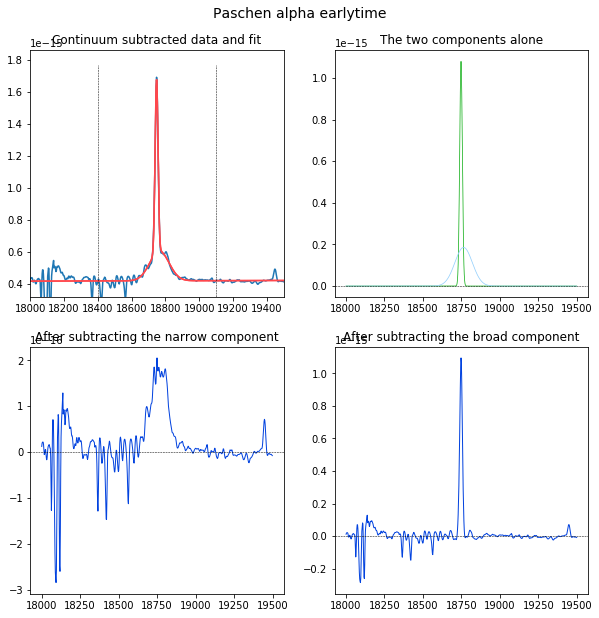

In [78]:
Res = resolution(1700,18751*(1+z)); print(Res)

HPa_0901 = do_fit(GNIRS_20170901,[18000,19500],[18400,19100],18751,title='Paschen alpha earlytime',
                  line_amps=(4E-16,1E-16,0,0),line_fwhms=(Res[1],40,0,0),fixed='no')

print("Narrow FWHM: ",(HPa_0901[0][0][2]/HPa_0901[0][0][1] *3E5*2.35).format('P'))
print("Broad FWHM: ",(HPa_0901[0][1][2]/HPa_0901[0][0][1] *3E5*2.35).format('P'))

print(HPa_0901[0][1],'\n',HPa_0901[0][2])
print('number of evals: ', HPa_0901[0][-2].fit_info['nfev'],'\n')
print_func(HPa_0901)

[18500, 19100]
(8.507961629389039e-15, 5.784590501824975e-16) (8.5+/-0.5)e-15
(1.9162085051286502e-14, 1.302836331285082e-15) (1.916+/-0.019)e-14
Narrow FWHM:  310.7±2.4
Broad FWHM:  (2.08±0.09)×10³
number of evals:  57 

N amp = (9.248±0.057)×10⁻¹⁶
N centre = 18754.185±0.056
N sigma = 8.266±0.063
B amp = (6.13±0.29)×10⁻¹⁷
B centre = 18769.4±2.2
B sigma = 55.4±2.4


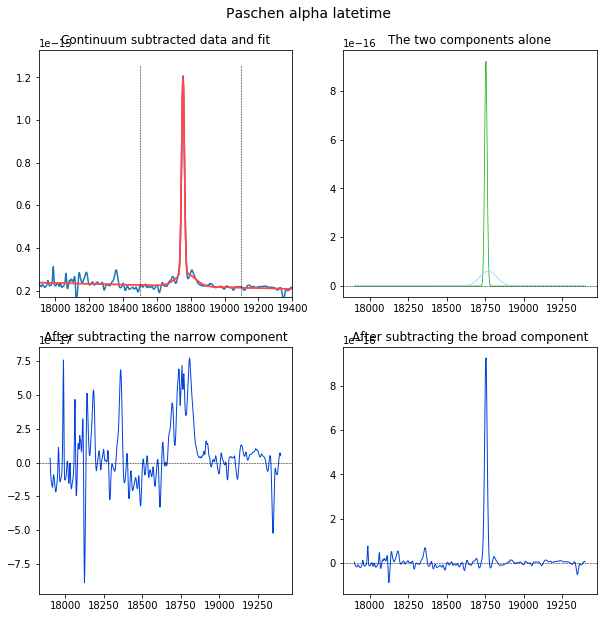

In [81]:
HPa_1123 = do_fit(GNIRS_20181123,[17900,19400],[18500,19100],18751,title='Paschen alpha latetime')
print("Narrow FWHM: ",(HPa_1123[0][0][2]/HPa_1123[0][0][1] *3E5*2.35).format('P'))
print("Broad FWHM: ",(HPa_1123[0][1][2]/HPa_1123[0][0][1] *3E5*2.35).format('P'))

print('number of evals: ', HPa_1123[0][-2].fit_info['nfev'],'\n')

print_func(HPa_1123)

[10700, 10900]
(1.2801427722198754e-14, 8.703731920158219e-16) (1.28+/-0.08)e-14
(8.145496375092867e-15, 5.538149208556462e-16) (8.15+/-0.25)e-15
Narrow FWHM:  383±9
Broad FWHM:  (2.39±0.10)×10³
number of evals:  86 

N amp = (5.52±0.11)×10⁻¹⁶
N centre = 10832.15±0.12
N sigma = 5.88±0.14
B amp = (1.393±0.065)×10⁻¹⁶
B centre = 10834.5±1.2
B sigma = 36.7±1.6


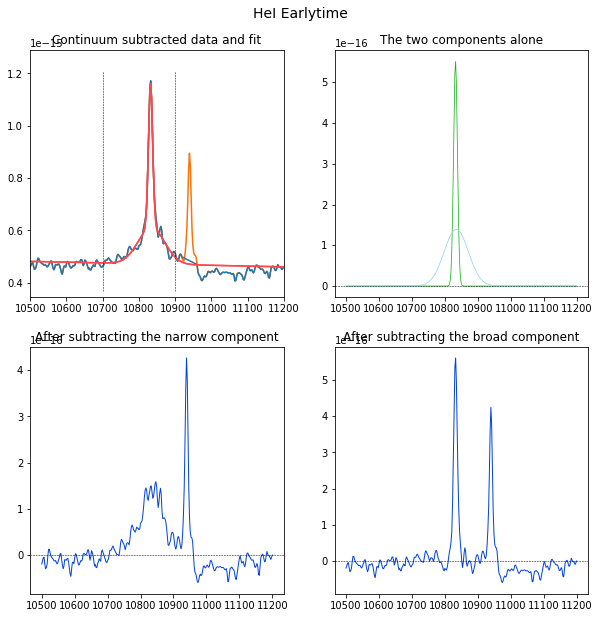

In [82]:
HeI_0901 = do_fit(GNIRS_20170901,[10500,11200],[10700,10900],10830,exclude=[10920,10960],
                  line_amps=(4E-16,1E-16,0,0),line_fwhms=(2,35,0,0),
                  title='HeI Earlytime')

print("Narrow FWHM: ",(HeI_0901[0][0][2]/HeI_0901[0][0][1] *3E5*2.35).format('P'))
print("Broad FWHM: ",(HeI_0901[0][1][2]/HeI_0901[0][0][1] *3E5*2.35).format('P'))

print('number of evals: ', HeI_0901[0][-2].fit_info['nfev'],'\n')

print_func(HeI_0901)

[10700, 10900]
(3.932965475743105e-15, 2.6740358884779086e-16) (3.9+/-0.4)e-15
(5.5028238981626955e-15, 3.7413876843012506e-16) (5.50+/-0.14)e-15
Narrow FWHM:  337±7
Broad FWHM:  (1.91±0.13)×10³
number of evals:  197


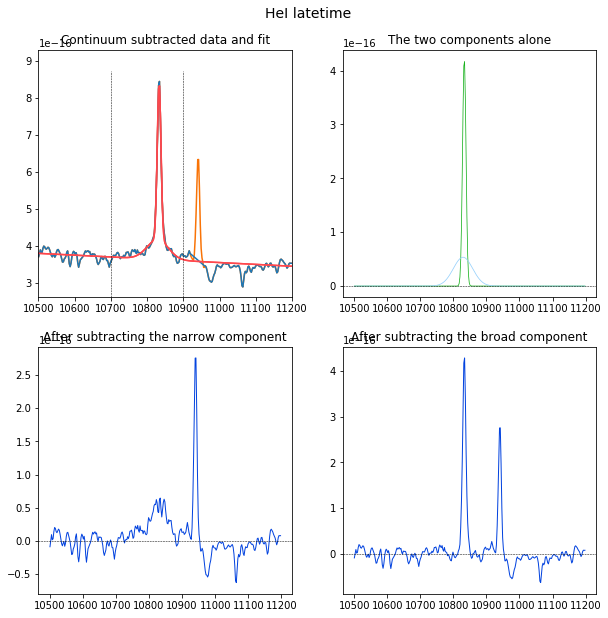

In [83]:
HeI_1123 = do_fit(GNIRS_20181123,[10500,11200],[10700,10900],10830,exclude=[10920,10960],
                  line_amps=(4E-16,1E-16,0,0),line_fwhms=(2,35,0,0),
                  title='HeI latetime')
print("Narrow FWHM: ",(HeI_1123[0][0][2]/HeI_1123[0][0][1] *3E5*2.35).format('P'))
print("Broad FWHM: ",(HeI_1123[0][1][2]/HeI_1123[0][0][1] *3E5*2.35).format('P'))

print('number of evals: ', HeI_1123[0][-2].fit_info['nfev'])

[12650, 12950]
(9.688291365382056e-15, 6.587100489033796e-16) (9.7+/-0.5)e-15
(8.608125259383714e-15, 5.852692075491184e-16) (8.61+/-0.18)e-15
Narrow FWHM:  283±5
Broad FWHM:  (1.72±0.06)×10³
(8.608130191530931e-15+/-1.7760471541516337e-16, 9.688296916426039e-15+/-5.236209530139545e-16)
number of evals:  50


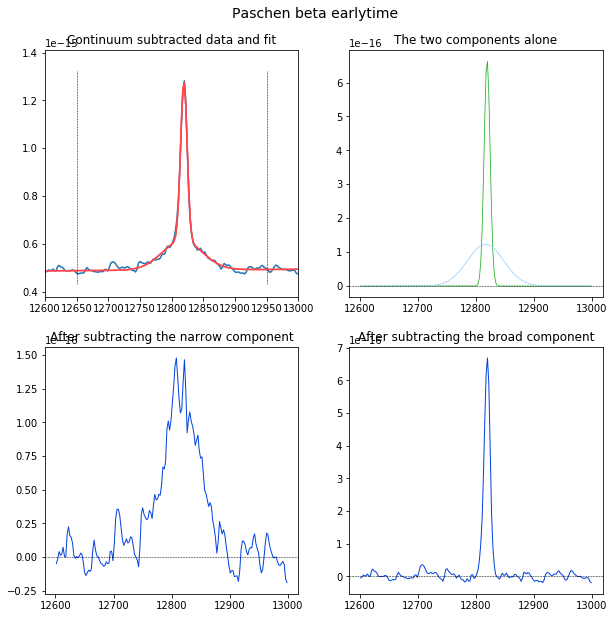

In [84]:
HPb_0901 = do_fit(GNIRS_20170901,[12600,13000],[12650,12950],12818,title='Paschen beta earlytime')

print("Narrow FWHM: ",(HPb_0901[0][0][2]/HPb_0901[0][0][1] *3E5*2.35).format('P'))
print("Broad FWHM: ",(HPb_0901[0][1][2]/HPb_0901[0][0][1] *3E5*2.35).format('P'))

print(HPb_0901[0][2])
print('number of evals: ', HPb_0901[0][-2].fit_info['nfev'])

No Covariance matrix, trying single line fit
[12650, 12950]
(7.618710854094805e-15, 5.179986036287606e-16) (7.62+/-0.15)e-15
Narrow FWHM:  288±4
Broad FWHM:  0.0±0
number of evals:  7
N amp = (5.810±0.076)×10⁻¹⁶
N centre = 12820.804±0.079
N sigma = 5.231±0.079
B amp = 0.0±0
B centre = 0.0±0
B sigma = 0.0±0


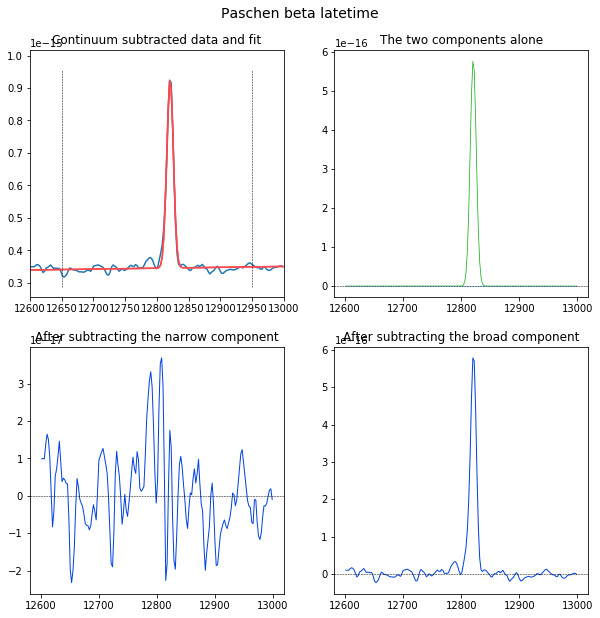

In [86]:
HPb_1123 = do_fit(GNIRS_20181123,[12600,13000],[12650,12950],12818,title='Paschen beta latetime')
print("Narrow FWHM: ",(HPb_1123[0][0][2]/HPb_1123[0][0][1] *3E5*2.35).format('P'))
print("Broad FWHM: ",(HPb_1123[0][1][2]/HPb_1123[0][0][1] *3E5*2.35).format('P'))

print('number of evals: ', HPb_1123[0][-2].fit_info['nfev'])

print_func(HPb_1123)

No Covariance matrix, trying single line fit
[10900, 10970]
(4.632442849715227e-15, 3.1496128070226815e-16) (4.63+/-0.24)e-15
Narrow FWHM:  300±12
Broad FWHM:  0.0±0
number of evals:  7
N amp = (3.97±0.14)×10⁻¹⁶
N centre = 10939.70±0.18
N sigma = 4.65±0.18
B amp = 0.0±0
B centre = 0.0±0
B sigma = 0.0±0


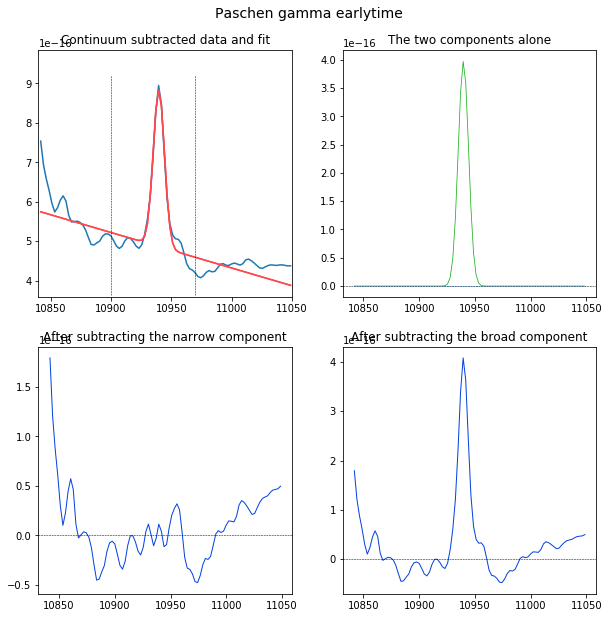

In [88]:
HPy_0901 = do_fit(GNIRS_20170901,[10840,11050],[10900,10970],10940,title='Paschen gamma earlytime')
print("Narrow FWHM: ",(HPy_0901[0][0][2]/HPy_0901[0][0][1] *3E5*2.35).format('P'))
print("Broad FWHM: ",(HPy_0901[0][1][2]/HPy_0901[0][0][1] *3E5*2.35).format('P'))

print('number of evals: ', HPy_0901[0][-2].fit_info['nfev'])

print_func(HPy_0901)

No Covariance matrix, trying single line fit
[10900, 10980]
(3.2236339752531947e-15, 2.1917591173265317e-16) (3.22+/-0.23)e-15
Narrow FWHM:  287±15
Broad FWHM:  0.0±0
number of evals:  7


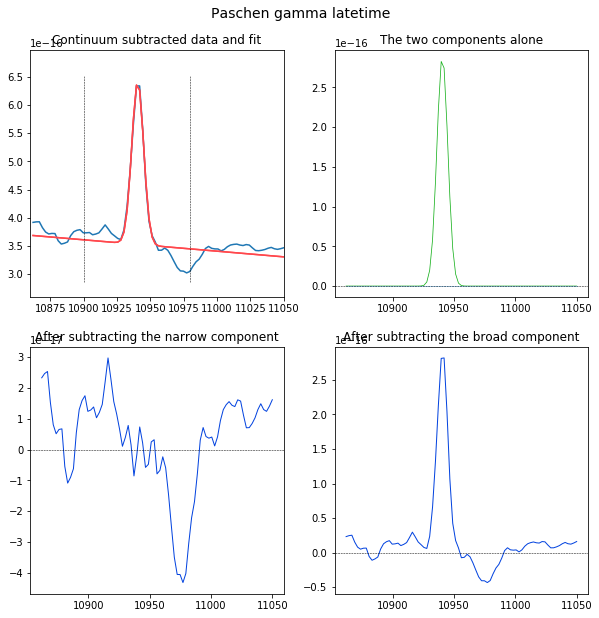

In [89]:
HPy_1123 = do_fit(GNIRS_20181123,[10860,11050],[10900,10980],10940,title='Paschen gamma latetime')

print("Narrow FWHM: ",(HPy_1123[0][0][2]/HPy_1123[0][0][1] *3E5*2.35).format('P'))
print("Broad FWHM: ",(HPy_1123[0][1][2]/HPy_1123[0][0][1] *3E5*2.35).format('P'))

print('number of evals: ', HPy_1123[0][-2].fit_info['nfev'])

[9970, 10110]
(7.535112134249986e-16, 5.123146998028497e-17) (7.5+/-1.7)e-16
(1.722522907474105e-15, 1.1711488700473469e-16) (1.72+/-0.08)e-15
Narrow FWHM:  293±11
Broad FWHM:  (1.47±0.27)×10³
number of evals:  95


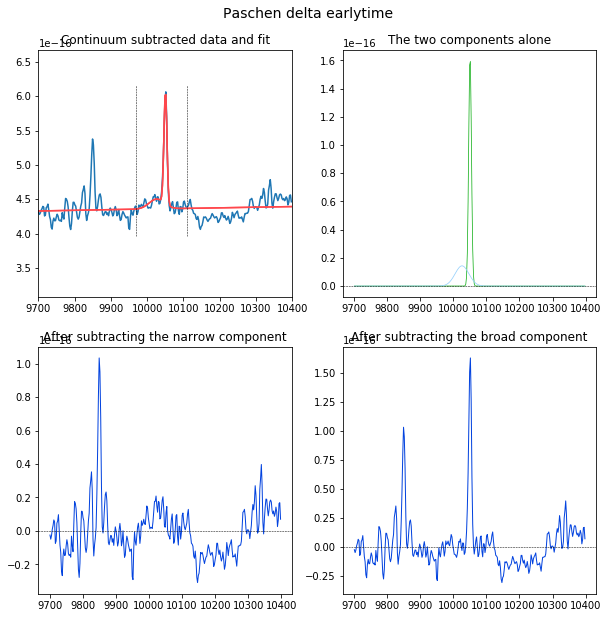

In [90]:
HPd_0901 = do_fit(GNIRS_20170901,[9700,10400],[9970,10110],10050,title='Paschen delta earlytime')

print("Narrow FWHM: ",(HPd_0901[0][0][2]/HPd_0901[0][0][1] *3E5*2.35).format('P'))
print("Broad FWHM: ",(HPd_0901[0][1][2]/HPd_0901[0][0][1] *3E5*2.35).format('P'))

print('number of evals: ', HPd_0901[0][-2].fit_info['nfev'])

No Covariance matrix, trying single line fit
[9920, 10170]
(1.4202278038181789e-15, 9.65617456123254e-17) (1.42+/-0.10)e-15
Narrow FWHM:  274±15
Broad FWHM:  0.0±0
number of evals:  7


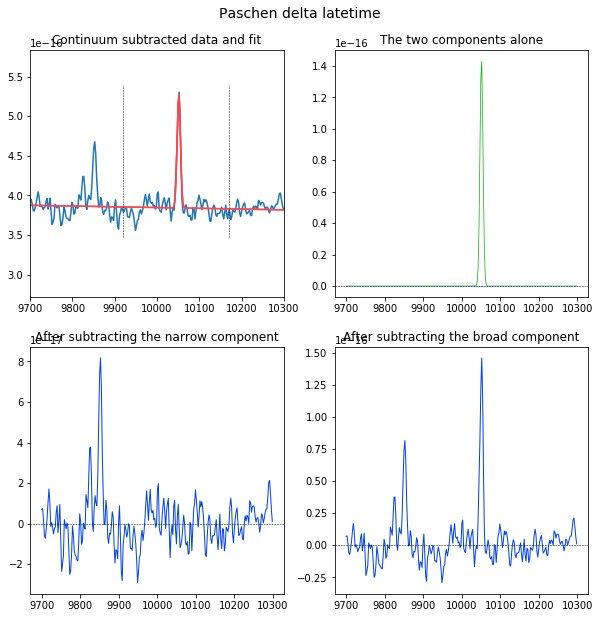

In [91]:
HPd_1123 = do_fit(GNIRS_20181123,[9700,10300],[9920,10170],10050,title='Paschen delta latetime')

print("Narrow FWHM: ",(HPd_1123[0][0][2]/HPd_1123[0][0][1] *3E5*2.35).format('P'))
print("Broad FWHM: ",(HPd_1123[0][1][2]/HPd_1123[0][0][1] *3E5*2.35).format('P'))
print('number of evals: ', HPd_1123[0][-2].fit_info['nfev'])

[21350, 21950]
(2.7185046107304283e-15, 1.8483200365774912e-16) (2.7+/-0.4)e-15
(2.0302657917334762e-15, 1.380384248025353e-16) (2.03+/-0.15)e-15
Narrow FWHM:  304±18
Broad FWHM:  (2.05±0.22)×10³
number of evals:  96


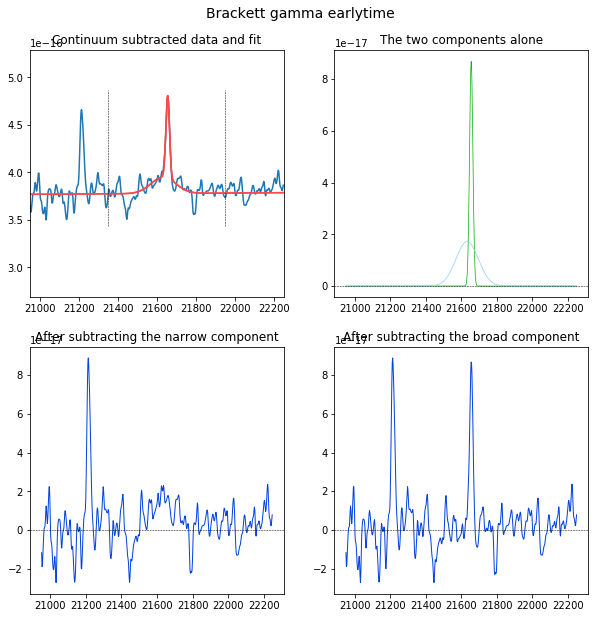

In [92]:
HBry_0901 = do_fit(GNIRS_20170901,[20950,22250],[21350,21950],21660,
                   line_amps=(1E-16,1E-16,0,0),line_fwhms=(12,100,0,0),#exclude=[21390,21520],
                   title='Brackett gamma earlytime')

print("Narrow FWHM: ",(HBry_0901[0][0][2]/HBry_0901[0][0][1] *3E5*2.35).format('P'))
print("Broad FWHM: ",(HBry_0901[0][1][2]/HBry_0901[0][0][1] *3E5*2.35).format('P'))

print('number of evals: ', HBry_0901[0][-2].fit_info['nfev'])

No Covariance matrix, trying single line fit
[21450, 21850]
(2.3086362126095766e-15, 1.5696491930730453e-16) (2.31+/-0.05)e-15
Narrow FWHM:  308±5
Broad FWHM:  0.0±0
number of evals:  6


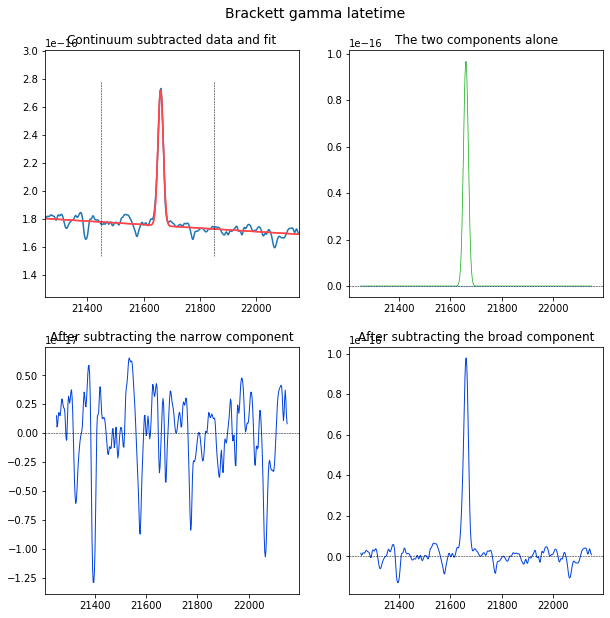

In [93]:
HBry_1123 = do_fit(GNIRS_20181123,[21250,22150],[21450,21850],21660,
                   line_amps=(1E-16,1E-17,0,0),line_fwhms=(8,500,0,0),#exclude=[21390,21520],                   
                   title='Brackett gamma latetime')

print("Narrow FWHM: ",(HBry_1123[0][0][2]/HBry_1123[0][0][1] *3E5*2.35).format('P'))
print("Broad FWHM: ",(HBry_1123[0][1][2]/HBry_1123[0][0][1] *3E5*2.35).format('P'))

print('number of evals: ', HBry_1123[0][-2].fit_info['nfev'])

No Covariance matrix, trying single line fit
[19250, 19500]
(1.5917589481073265e-15, 1.0822420331022478e-16) (1.59+/-0.11)e-15
Narrow FWHM:  295±15
Broad FWHM:  0.0±0


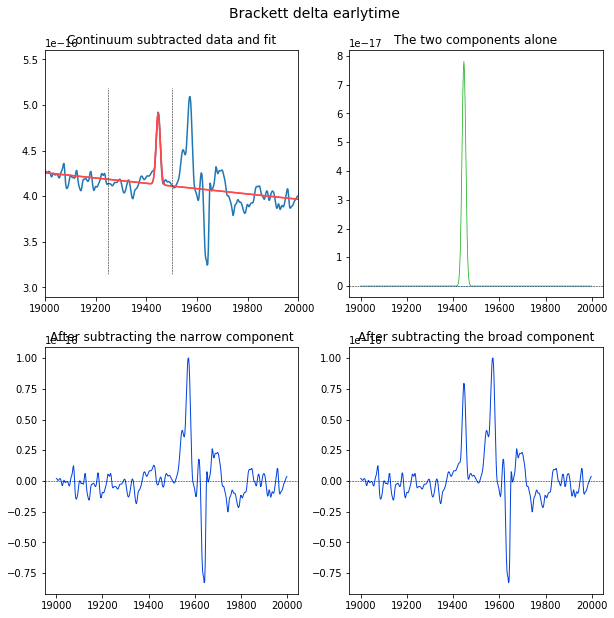

In [94]:
HBrd_0901 = do_fit(GNIRS_20170901,[19000,20000],[19250,19500],19440,
                   line_amps=(1E-16,1E-17,0,0),line_fwhms=(8,75,0,0),#exclude=[19520,19600],
                   title='Brackett delta earlytime')

print("Narrow FWHM: ",(HBrd_0901[0][0][2]/HBrd_0901[0][0][1] *3E5*2.35).format('P'))
print("Broad FWHM: ",(HBrd_0901[0][1][2]/HBrd_0901[0][0][1] *3E5*2.35).format('P'))

No Covariance matrix, trying single line fit
[19250, 19600]
(1.2239315990747536e-15, 8.321550345185693e-17) (1.22+/-0.35)e-15
Narrow FWHM:  (2.9±0.6)×10²
Broad FWHM:  0.0±0


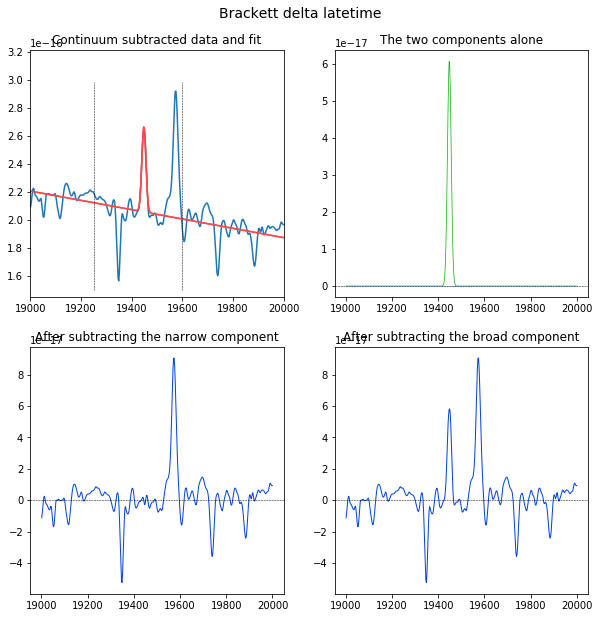

In [95]:
HBrd_1123 = do_fit(GNIRS_20181123,[19000,20000],[19250,19600],19440,
            line_amps=(1E-16,1E-17,0,0),line_fwhms=(8,50,0,0),#exclude=[19520,19600],
                   title='Brackett delta latetime')

print("Narrow FWHM: ",(HBrd_1123[0][0][2]/HBrd_1123[0][0][1] *3E5*2.35).format('P'))
print("Broad FWHM: ",(HBrd_1123[0][1][2]/HBrd_1123[0][0][1] *3E5*2.35).format('P'))

[8350, 8550]
(3.966045205681002e-15, 2.696526903367297e-16) (4.0+/-0.4)e-15
(3.5934880361163895e-16, 2.443224083578608e-17) (3.6+/-1.1)e-16
N amp = (6.2±1.2)×10⁻¹⁷
N centre = 8449.33±0.51
N sigma = 2.31±0.56
B amp = (7.16±0.49)×10⁻¹⁷
B centre = 8449.8±1.3
B sigma = 22.1±1.5


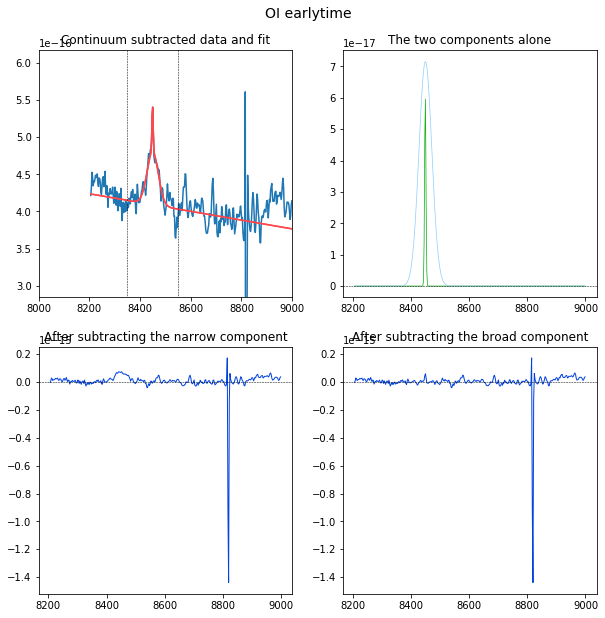

In [97]:
OI_8_0901 = do_fit(GNIRS_20170901,[8000,9000],[8350,8550],8448,
                   line_amps=(1E-16,1E-16,0,0),line_fwhms=(4,30,0,0),#exclude=[19520,19600],
                   title='OI earlytime')

print_func(OI_8_0901)

No Covariance matrix, trying single line fit
[11105, 11555]
(6.297109331897355e-15, 4.281424907204831e-16) (6.3+/-0.4)e-15
N amp = (6.63±0.30)×10⁻¹⁷
N centre = 11291.7±2.0
N sigma = 37.9±2.0
B amp = 0.0±0
B centre = 0.0±0
B sigma = 0.0±0


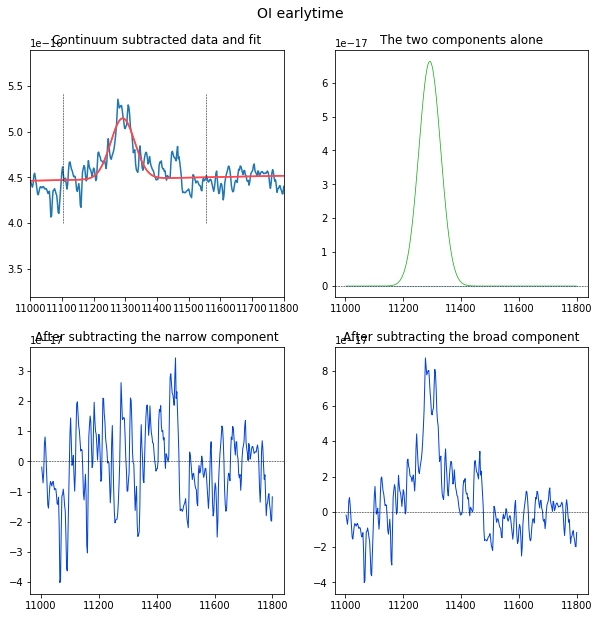

In [111]:
OI_11_0901 = do_fit(GNIRS_20170901,[11000,11800],[11105,11555],11287,
                   line_amps=(1E-16,1E-16,0,0),line_fwhms=(30,0,0,0),#exclude=[19520,19600],
                   title='OI earlytime')

print_func(OI_11_0901)

No Covariance matrix, trying single line fit
[8350, 8550]
(2.67190765437819e-16, 1.8166386158789962e-17) (2.7+/-2.6)e-16
N amp = (2.4±1.5)×10⁻¹⁷
N centre = 8446.6±3.2
N sigma = 4.4±3.2
B amp = 0.0±0
B centre = 0.0±0
B sigma = 0.0±0


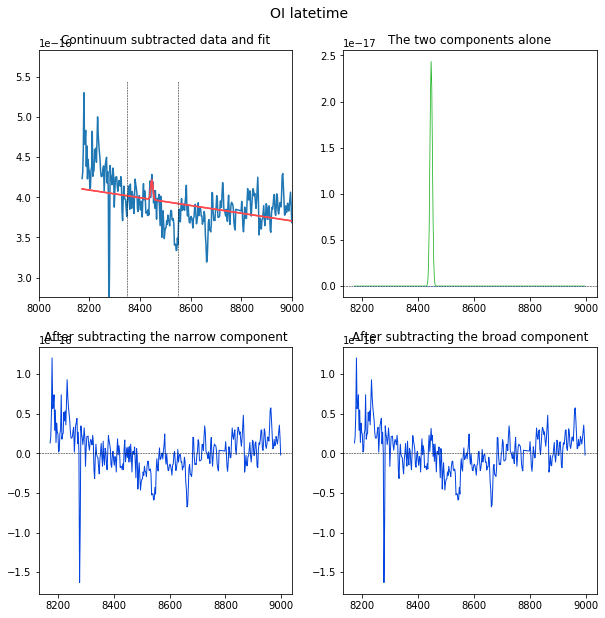

In [135]:
OI_8_1123 = do_fit(GNIRS_20181123,[8000,9000],[8350,8550],8448,
                   line_amps=(1E-16,1E-16,0,0),line_fwhms=(4,30,0,0),#exclude=[19520,19600],
                   title='OI latetime')

print_func(OI_8_1123)

No Covariance matrix, trying single line fit
[11105, 11555]
(1.2361267569602006e-15, 8.404465615515499e-17) (1.24+/-0.31)e-15
N amp = (6.63±0.30)×10⁻¹⁷
N centre = 11291.7±2.0
N sigma = 37.9±2.0
B amp = 0.0±0
B centre = 0.0±0
B sigma = 0.0±0


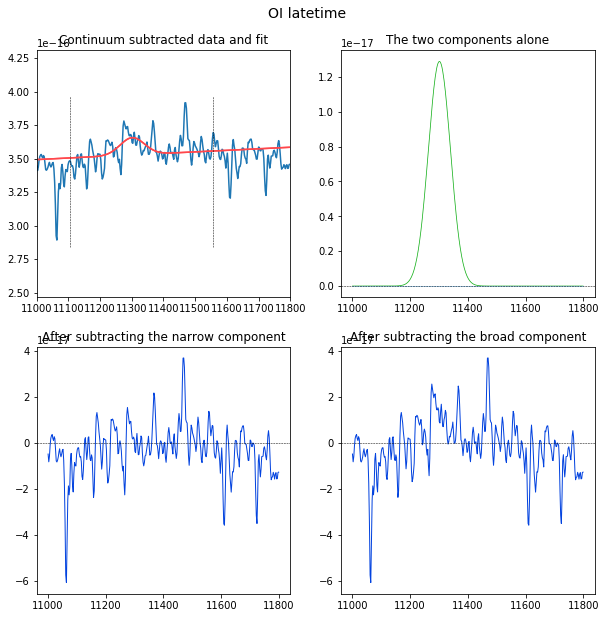

In [134]:
OI_11_1123 = do_fit(GNIRS_20181123,[11000,11800],[11105,11555],11287,
                   line_amps=(1E-16,1E-16,0,0),line_fwhms=(30,0,0,0),#exclude=[19520,19600],
                   title='OI latetime')

print_func(OI_11_1123)

In [154]:
from astropy.table import Table, Column,vstack

def table_func(fit_output_1,fit_output_2, rest_wav,title):
    T = Table()
    T['line']  = [title[0],title[1]]
    T['epoch']  = ['20170910','20181123']
    T['line_1_position']  = [fit_output_1[0][0][1],fit_output_2[0][0][1]]
    T['line_1_offset'] = [(fit_output_1[0][0][1]-rest_wav)/rest_wav * 3E5,
                                  (fit_output_2[0][0][1]-rest_wav)/rest_wav * 3E5]
    T['line_1_fwhm'] = [(((2*np.sqrt(2*np.log(2))) *fit_output_1[0][0][2]))/fit_output_1[0][0][1] * 3E5,
               (((2*np.sqrt(2*np.log(2))) *fit_output_2[0][0][2]))/fit_output_2[0][0][1] * 3E5]
    try :
        T['line_2_position']  = [fit_output_1[0][1][1],fit_output_2[0][1][1]]
        T['line_2_offset'] = [(fit_output_1[0][1][1]-rest_wav)/rest_wav * 3E5,
                                  (fit_output_2[0][1][1]-rest_wav)/rest_wav * 3E5]
        T['line_2_fwhm'] = [(((2*np.sqrt(2*np.log(2))) *fit_output_1[0][1][2]))/fit_output_1[0][1][1] * 3E5,
               (((2*np.sqrt(2*np.log(2))) *fit_output_2[0][1][2]))/fit_output_2[0][1][1] * 3E5]
    except ZeroDivisionError :
        T['line_2_position'] = [ufloat(0,0),ufloat(0,0)]
        T['line_2_offset'] = [ufloat(0,0),ufloat(0,0)]
        T['line_2_fwhm'] = [ufloat(0,0),ufloat(0,0)] 
        
    return T
    
T_HPa = table_func(HPa_0901,HPa_1123,18751,('Paschen','alpha'))
T_HPb = table_func(HPb_0901,HPb_1123,12818,('Paschen','beta'))    
T_HPy = table_func(HPy_0901,HPy_1123,10940,('Paschen','gamma'))    
T_HPd = table_func(HPy_0901,HPd_1123,10940,('Paschen','delta'))    
T_HeI = table_func(HeI_0901,HeI_1123,10050,('HeI',''))    
T_HBry = table_func(HBry_0901,HBry_1123,21660,('Brackett','gamma'))    
T_OI_8 = table_func(OI_8_0901,OI_8_1123,8446,('OI','8446'))    
T_OI_11 = table_func(OI_11_0901,OI_11_1123,11247,('OI','11247'))    


full_table = vstack([T_HPa,T_HPb,T_HPy,T_HPd,T_HeI,T_HBry,T_OI_8,T_OI_11])
#full_table.pprint(max_lines=-1, max_width=-1)
# T_HPa.pprint(max_lines=-1, max_width=-1)
# T_HPb.pprint(max_lines=-1, max_width=-1)
# T_HPy.pprint(max_lines=-1, max_width=-1)
# T_HPd.pprint(max_lines=-1, max_width=-1)
# T_HeI.pprint(max_lines=-1, max_width=-1)
# T_HBry.pprint(max_lines=-1, max_width=-1)
# T_OI_8.pprint(max_lines=-1, max_width=-1)
# T_OI_11.pprint(max_lines=-1, max_width=-1)

full_table.show_in_notebook()

idx,line,epoch,line_1_position,line_1_offset,line_1_fwhm,line_2_position,line_2_offset,line_2_fwhm
0,Paschen,20170910,18747.34+/-0.12,-58.6+/-1.9,324+/-5,18764.1+/-1.8,209+/-29,(2.14+/-0.07)e+03
1,alpha,20181123,18754.18+/-0.06,51.0+/-0.9,311.4+/-2.4,18769.4+/-2.2,(2.9+/-0.4)e+02,(2.09+/-0.09)e+03
2,Paschen,20170910,12819.33+/-0.07,31.2+/-1.6,284+/-5,0.0+/-0,0.0+/-0,0.0+/-0
3,beta,20181123,12820.80+/-0.08,65.6+/-1.8,288+/-4,0.0+/-0,0.0+/-0,0.0+/-0
4,Paschen,20170910,10939.70+/-0.18,-8+/-5,300+/-12,0.0+/-0,0.0+/-0,0.0+/-0
5,gamma,20181123,10940.54+/-0.24,15+/-7,288+/-15,0.0+/-0,0.0+/-0,0.0+/-0
6,Paschen,20170910,10939.70+/-0.18,-8+/-5,300+/-12,0.0+/-0,0.0+/-0,0.0+/-0
7,delta,20181123,10051.53+/-0.22,-24364+/-6,275+/-15,0.0+/-0,0.0+/-0,0.0+/-0
8,HeI,20170910,10832.15+/-0.12,23348+/-4,384+/-9,10834.5+/-1.2,(2.342+/-0.004)e+04,(2.39+/-0.10)e+03
9,,20181123,10833.03+/-0.09,23374.0+/-2.6,338+/-7,10829.2+/-1.6,(2.326+/-0.005)e+04,(1.91+/-0.13)e+03


In [155]:
#Extinction calcs

HPa_Pb_20170901_ratio = HPa_0901[0][2][0] / HPb_0901[0][2][0]

HPa_Pb_20181123_ratio =HPa_1123[0][2][0] / HPb_1123[0][2][0]

HPa_Pb_20170901_ratio_broad = HPa_0901[0][2][1] / HPb_0901[0][2][1]
                               
HPa_Py_20170901_ratio = HPa_0901[0][2][0] / HPy_0901[0][2][0]

HPa_Py_20181123_ratio = HPa_1123[0][2][0] / HPy_1123[0][2][0]

HPa_Pd_20170901_ratio = HPa_0901[0][2][0] / HPd_0901[0][2][0]

HPa_Pd_20181123_ratio  = HPa_1123[0][2][0] / HPd_1123[0][2][0]

HPa_Brackett_20170901_ratio_broad = HPa_0901[0][2][1] / HBry_0901[0][2][1]

HPb_Brackett_20170901_ratio_broad = HPb_0901[0][2][1] / HBry_0901[0][2][1]

theoretical_HPa_HPb = 0.332 / (0.345 * 0.469)
theoretical_HPa_HPy = 0.332 / (0.346 * 0.260)
theoretical_HPa_HPd = 0.332 / (0.348 * 0.159)
#theoretical_HPa_Bry = 0.332 /

print(HPa_Pb_20170901_ratio_broad)
#print(HPa_Pb_20170901_ratio,HPa_Py_20170901_ratio,HPa_Pd_20170901_ratio)
#print(HPa_Pb_20181123_ratio,HPa_Py_20181123_ratio,HPa_Pd_20181123_ratio)
print(theoretical_HPa_HPb,theoretical_HPa_HPy,theoretical_HPa_HPd)


from extinction import ccm89, remove, apply
import extinction
paschen = np.array([18751.0,12818.0,10940,10050])
ext = extinction.ccm89(paschen, 1, 3.1)

#Assuming we are doing this right then:

A_V_transient_HPa_Pb_broad = (-2.5*um.log10(HPa_Pb_20170901_ratio_broad/theoretical_HPa_HPb))/(ext[0]-ext[1])
A_V_transient_HPa_Pb = (-2.5*um.log10(HPa_Pb_20170901_ratio/theoretical_HPa_HPb))/(ext[0]-ext[1])
A_V_transient_HPa_Py = (-2.5*um.log10(HPa_Py_20170901_ratio/theoretical_HPa_HPy))/(ext[0]-ext[2])
A_V_transient_HPa_Pd = (-2.5*um.log10(HPa_Pd_20170901_ratio/theoretical_HPa_HPd))/(ext[0]-ext[3])

A_V_quiescent_HPa_Pb = (-2.5*um.log10(HPa_Pb_20181123_ratio/theoretical_HPa_HPb))/(ext[0]-ext[1])
A_V_quiescent_HPa_Py = (-2.5*um.log10(HPa_Py_20181123_ratio/theoretical_HPa_HPy))/(ext[0]-ext[2])
A_V_quiescent_HPa_Pd = (-2.5*um.log10(HPa_Pd_20181123_ratio/theoretical_HPa_HPd))/(ext[0]-ext[3])
print('Derived values of A_V')
print('Broad line in transient spectrum,alpha to B: ',
      A_V_transient_HPa_Pb_broad)
print('Narrow line in transient spectrum, alpha to B,y,d: ', 
      A_V_transient_HPa_Pb,A_V_transient_HPa_Py,A_V_transient_HPa_Pd)
print('Narrow line quiescent spectrum, alpha to B,y,d: ',
      A_V_quiescent_HPa_Pb,A_V_quiescent_HPa_Py,A_V_quiescent_HPa_Pd)

# %matplotlib inline
# %config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import pyneb as pn

print(pn.atomicData.getAllAvailableFiles('H1'),'\n')
#pn.atomicData.setDataFile('h_i_trc_SH95-caseB.dat')
H1 = pn.RecAtom('H', 1)
#print(pn.atomicData.getDataFile('H1', 'rec'))
Halpha = H1.getEmissivity(tem=1e4, den=1e3, lev_i=3, lev_j=2)
Hbeta = H1.getEmissivity(tem=1e4, den=1e3, lev_i=4, lev_j=2)

HPalpha = H1.getEmissivity(tem=1e4, den=1e3, lev_i=4, lev_j=3)
HPbeta = H1.getEmissivity(tem=1e4, den=1e3, lev_i=5, lev_j=3)
HPgamma = H1.getEmissivity(tem=1e4, den=1e3, lev_i=6, lev_j=3)
HPdelta = H1.getEmissivity(tem=1e4, den=1e3, lev_i=7, lev_j=3)

HBrgamma = H1.getEmissivity(tem=1e4, den=1e3, lev_i=7, lev_j=4)
HBrdelta = H1.getEmissivity(tem=1e4, den=1e3, lev_i=8, lev_j=4)

print(Halpha/Hbeta)
print(HPalpha/HPbeta)
print(HPalpha/HPgamma)
print(HPalpha/HPdelta)
print(HBrgamma/HBrdelta)

#pn.RedCorr().PrintLaws()
#print(pn.RedCorr().getLaws()
r_v=3.1
rc1 = pn.RedCorr(E_BV = 10, R_V = r_v, law = 'CCM89')
#rc.cHbeta

rc1.setCorr(obs_over_theo= HPa_Pb_20170901_ratio_broad.n / (HPalpha/HPbeta), wave1=18751., wave2=12818.)
print('Extinction derived from broad HPa/HPb: ', rc1.E_BV * r_v,'\n-----------')

rc1.setCorr(obs_over_theo= HPa_Brackett_20170901_ratio_broad.n / (HPalpha/HBrgamma), wave1=18751., wave2=21660.)
print('Extinction derived from broad HPa/HBry: ', rc1.E_BV * r_v,'theoretical:',HPalpha/HBrgamma,'\n-----------')

rc1.setCorr(obs_over_theo= HPb_Brackett_20170901_ratio_broad.n / (HPbeta/HBrgamma), wave1=12818., wave2=21660.)
print('Extinction derived from broad HPb/HBry: ', rc1.E_BV * r_v,'theoretical:',HPbeta/HBrgamma,'\n-----------')

# rc1.setCorr(obs_over_theo= HPa_Pb_20170901_ratio / (HPalpha/HPbeta), wave1=18751., wave2=12818.)
# print('Extinction derived from HPa/HPb: ', rc1.E_BV * r_v)

# rc1.setCorr(obs_over_theo= HPa_Py_20170901_ratio / (HPalpha/HPgamma), wave1=18751., wave2=10940.)
# print('Extinction derived from HPa/HPy: ', rc1.E_BV * r_v)

# rc1.setCorr(obs_over_theo= HPa_Pd_20170901_ratio / (HPalpha/HPdelta), wave1=18751., wave2=10050.)
# print('Extinction derived from HPa/HPd: ', rc1.E_BV * r_v,'\n-----------')


# rc1.setCorr(obs_over_theo= HPa_Pb_20181123_ratio/ (HPalpha/HPbeta), wave1=18751., wave2=12818.)
# print('Extinction derived from HPa/HPb: ', rc1.E_BV * r_v)

# rc1.setCorr(obs_over_theo= HPa_Py_20181123_ratio / (HPalpha/HPgamma), wave1=18751., wave2=10940.)
# print('Extinction derived from HPa/HPy: ', rc1.E_BV * r_v)

# rc1.setCorr(obs_over_theo= HPa_Pd_20181123_ratio / (HPalpha/HPdelta), wave1=18751., wave2=10050.)
# print('Extinction derived from HPa/HPd: ', rc1.E_BV * r_v)


print(A_V_transient_HPa_Pb_broad)


2.73+/-0.20
2.051852538549489 3.6905291240551357 6.000144581797152
Derived values of A_V
Broad line in transient spectrum,alpha to B:  2.5+/-0.6
Narrow line in transient spectrum, alpha to B,y,d:  2.42+/-0.25 1.65+/-0.30 3.47+/-0.22
Narrow line quiescent spectrum, alpha to B,y,d:  1.78+/-0.19 2.6+/-0.4 3.46+/-0.31
['h_i_rec_P91.func', 'h_i_rec_SH95-caseA.fits', 'h_i_rec_SH95-caseA.hdf5', 'h_i_rec_SH95.fits', 'h_i_rec_SH95.hdf5', 'h_i_trc_SH95-caseA.dat', 'h_i_trc_SH95-caseB.dat'] 

2.856911883589329
2.0645481628599804
3.722470904207699
6.064760793465577
1.5215268530847759
Extinction derived from broad HPa/HPb:  2.4509418005083563 
-----------
Extinction derived from broad HPa/HBry:  7.845445574292144 theoretical: 12.129521586931155 
-----------
Extinction derived from broad HPb/HBry:  3.5133403761314947 theoretical: 5.8751458576429405 
-----------
2.5+/-0.6


In [156]:
print ("Extinction from HPa/HPb:", A_V_transient_HPa_Pb_broad)
rc1.setCorr(obs_over_theo= HPa_Pb_20170901_ratio_broad.n / (HPalpha/HPbeta), wave1=18751., wave2=12818.)
print('Extinction derived from broad HPa/HPb: ', rc1.E_BV * r_v,'\n-----------')

#Extinction from Brackett line ratios
HPb_Bry_20170901_ratio_broad = HPb_0901[0][2][1] / HBry_0901[0][2][1]
#print(HPb_Bracketty_20170901_ratio_broad)
theoretical_HPb_Bry = HPbeta/HBrgamma
lines = np.array([12818.0,21660.0])
ext = extinction.ccm89(lines, 1, 3.1)
#print(ext)
A_V_transient_HPb_Bry_broad = (-2.5*um.log10(
    HPb_Bry_20170901_ratio_broad /theoretical_HPb_Bry))/(ext[0]-ext[1])

print ("Extinction from HPb/Bry:", A_V_transient_HPb_Bry_broad)
rc1.setCorr(obs_over_theo= HPb_Bry_20170901_ratio_broad.n/ (HPbeta/HBrgamma), wave1=12820., wave2=21660.)
print('Extinction derived from HPb/HBy: ', rc1.E_BV * 3.1,'\n-----------')

HPa_Bry_20170901_ratio_broad = HPa_0901[0][2][1] / HBry_0901[0][2][1]
theoretical_HPa_Bry = HPalpha/HBrgamma
#print(HPa_Bry_20170901_ratio_broad)
lines = np.array([18750,21660.0])
ext = extinction.ccm89(lines, 1, 3.1)
A_V_transient_HPa_Bry_broad = (-2.5*um.log10(
    HPa_Bry_20170901_ratio_broad /theoretical_HPa_Bry))/(ext[0]-ext[1])
print ("Extinction from HPa/Bry:", A_V_transient_HPa_Bry_broad)
rc1.setCorr(obs_over_theo= HPa_Bry_20170901_ratio_broad.n/ (HPalpha/HBrgamma), wave1=18751., wave2=21660.)
print('Extinction derived from HPb/HBy: ', rc1.E_BV * 3.1,'\n-----------')

#Extinction from Brackett line ratios
HPb_Bry_20170901_ratio_narrow = HPb_0901[0][2][0] / HBry_0901[0][2][0]
#print(HPb_Bracketty_20170901_ratio_broad)
lines = np.array([12818.0,21660.0])
ext = extinction.ccm89(lines, 1, 3.1)
#print(ext)
A_V_transient_HPb_Bry_narrow = (-2.5*um.log10(
    HPb_Bry_20170901_ratio_narrow /theoretical_HPb_Bry))/(ext[0]-ext[1])

print ("Extinction from HPb/Bry NARROW:", A_V_transient_HPb_Bry_narrow)
rc1.setCorr(obs_over_theo= HPb_Bry_20170901_ratio_narrow.n/ (HPbeta/HBrgamma), wave1=12820., wave2=21660.)
print('Extinction derived from HPb/HBy NARROW: ', rc1.E_BV * 3.1,'\n-----------')


HPb_Bry_20170901_ratio_narrow = HPb_1123[0][2][0] / HBry_1123[0][2][0]
#print(HPb_Bracketty_20170901_ratio_broad)
lines = np.array([12818.0,21660.0])
ext = extinction.ccm89(lines, 1, 3.1)
#print(ext)
A_V_transient_HPb_Bry_narrow = (-2.5*um.log10(
    HPb_Bry_20170901_ratio_narrow /theoretical_HPb_Bry))/(ext[0]-ext[1])

print ("Extinction from HPb/Bry NARROW:", A_V_transient_HPb_Bry_narrow)
rc1.setCorr(obs_over_theo= HPb_Bry_20170901_ratio_narrow.n/ (HPbeta/HBrgamma), wave1=12820., wave2=21660.)
print('Extinction derived from HPb/HBy NARROW: ', rc1.E_BV * 3.1,'\n-----------')

Extinction from HPa/HPb: 2.5+/-0.6
Extinction derived from broad HPa/HPb:  2.4509418005083563 
-----------
Extinction from HPb/Bry: 3.5+/-1.2
Extinction derived from HPb/HBy:  3.514888361225031 
-----------
Extinction from HPa/Bry: 8+/-6
Extinction derived from HPb/HBy:  7.845445574292144 
-----------
Extinction from HPb/Bry NARROW: 2.3+/-0.5
Extinction derived from HPb/HBy NARROW:  2.2935329819616586 
-----------
Extinction from HPb/Bry NARROW: 4.05+/-0.21
Extinction derived from HPb/HBy NARROW:  4.055492977206408 
-----------


In [157]:
import matplotlib.pyplot as plt
import pyneb as pn

print(pn.atomicData.getAllAvailableFiles('H1'),'\n')
pn.atomicData.setDataFile('h_i_trc_SH95-caseB.dat')
H1 = pn.RecAtom('H', 1)
#print(pn.atomicData.getDataFile('H1', 'rec'))
pn.atomicData.setDataFile('h_i_trc_SH95-caseB.dat')
Halpha = H1.getEmissivity(tem=1e4, den=1e3, lev_i=3, lev_j=2)
Hbeta = H1.getEmissivity(tem=1e4, den=1e3, lev_i=4, lev_j=2)

HPalpha = H1.getEmissivity(tem=1e4, den=1e3, lev_i=4, lev_j=3)
HPbeta = H1.getEmissivity(tem=1e4, den=1e3, lev_i=5, lev_j=3)
HPgamma = H1.getEmissivity(tem=1e4, den=1e3, lev_i=6, lev_j=3)
HPdelta = H1.getEmissivity(tem=1e4, den=1e3, lev_i=7, lev_j=3)

HBrgamma = H1.getEmissivity(tem=1e4, den=1e3, lev_i=7, lev_j=4)
HBrdelta = H1.getEmissivity(tem=1e4, den=1e3, lev_i=8, lev_j=4)

# print(Halpha/Hbeta)
# print(Hbeta/Halpha)
print(Halpha/HPalpha)
# print(HPalpha/HPbeta)
# print(HPalpha/HPgamma)
# print(HPalpha/HPdelta)
# print(HBrgamma/HBrdelta)

#pn.RedCorr().PrintLaws()
#print(pn.RedCorr().getLaws()
r_v=3.1
rc1 = pn.RedCorr(E_BV = 10, R_V = r_v, law = 'CCM89')
print(rc1.cHbeta)
H_alpha_flux = 7.293016026787286e-14; HP_alpha_flux = 2.3698715050045175e-14
HP_beta_flux = 7.872041597827244e-15

Halpha_to_Paschalpha = H_alpha_flux / HP_alpha_flux
Halpha_to_Paschbeta = H_alpha_flux / HP_beta_flux

print(Halpha_to_Paschalpha)
print(Halpha_to_Paschbeta)


rc1.setCorr(obs_over_theo= Halpha_to_Paschalpha / (Halpha/HPalpha), wave1=6784., wave2=19400.)
print('Extinction derived from broad Ha/HPa: ', rc1.E_BV * r_v)#,'theoretical:',Halpha/HPalpha,'\n-----------')

rc1.setCorr(obs_over_theo= Halpha_to_Paschbeta / (Halpha/HPbeta), wave1=6784., wave2=13256.)
print('Extinction derived from broad Ha/HPb: ', rc1.E_BV * r_v)#,'theoretical:',Halpha/HPalpha,'\n-----------')

rc1.setCorr(obs_over_theo= HPa_Pb_20170901_ratio_broad.n / (HPalpha/HPbeta), wave1=18751., wave2=12818.)
print('Extinction derived from broad HPa/HPb: ', rc1.E_BV * r_v,'\n-----------')

from extinction import ccm89, remove, apply
import extinction
lines = np.array([6784,19400.0])
ext = extinction.ccm89(lines, 1, 3.1)

theoretical_HBa_HPa = 2.85 / (0.322)
#print("THIS:",theoretical_HBa_HPa)

#Assuming we are doing this right then:

A_V_transient_HBa_HPa_broad = (-2.5*um.log10(Halpha_to_Paschalpha/theoretical_HBa_HPa))/(ext[0]-ext[1])
print("result:",A_V_transient_HBa_HPa_broad )


['h_i_rec_P91.func', 'h_i_rec_SH95-caseA.fits', 'h_i_rec_SH95-caseA.hdf5', 'h_i_rec_SH95.fits', 'h_i_rec_SH95.hdf5', 'h_i_trc_SH95-caseA.dat', 'h_i_trc_SH95-caseB.dat'] 

8.4992784992785
14.435606841343391
3.077388799935541
9.26445311061393
Extinction derived from broad Ha/HPa:  1.7110203293857948
Extinction derived from broad Ha/HPb:  1.3158240539387074
Extinction derived from broad HPa/HPb:  2.4509418005083563 
-----------
result: 1.7793019092995082


In [161]:
#broad line ratios

Paschbeta_to_Paschalpha = HPb_0901[0][2][1] /  HPa_0901[0][2][1] 
Paschgamma_to_Paschalpha = HPy_0901[0][2][1] / HPa_0901[0][2][1]
Paschdelta_to_Paschalpha = HPd_0901[0][2][1] / HPa_0901[0][2][1]
HeI_to_Paschalpha = HeI_0901[0][2][1] / HPa_0901[0][2][1]
Bry_to_Paschalpha = HBry_0901[0][2][1] / HPa_0901[0][2][1]
Brd_to_Paschalpha = HBrd_0901[0][2][1] / HPa_0901[0][2][1]
OI_8_to_Paschalpha = OI_8_0901[0][2][1] / HPa_0901[0][2][1]
OI_11_to_Paschalpha = OI_11_0901[0][2][1] / HPa_0901[0][2][1]
#OI_8_to_OI_11 =  OI_8_0901[0][2][1] / OI_11_0901[0][2][1]
print(Paschbeta_to_Paschalpha,Paschgamma_to_Paschalpha,
      Paschdelta_to_Paschalpha,Bry_to_Paschalpha,Brd_to_Paschalpha,HeI_to_Paschalpha,
     OI_8_to_Paschalpha,OI_11_to_Paschalpha)

0.366+/-0.027 0.0+/-0 0.028+/-0.007 0.103+/-0.017 0.0+/-0 0.48+/-0.04 0.150+/-0.016 0.0+/-0


In [162]:
#Do Narrow lines evolve?

HPa_evo = HPa_0901[0][2][0] / HPa_1123[0][2][0]
HPb_evo = HPb_0901[0][2][0] / HPb_1123[0][2][0]
HPy_evo = HPy_0901[0][2][0] / HPy_1123[0][2][0]
HPd_evo = HPd_0901[0][2][0] / HPd_1123[0][2][0]

HBry_evo = HBry_0901[0][2][0] / HBry_1123[0][2][0]
HBrd_evo = HBrd_0901[0][2][0] / HBrd_1123[0][2][0]


HPa_flux_diff = HPa_0901[0][2][0] - HPa_1123[0][2][0]
HPb_flux_diff = HPb_0901[0][2][0] - HPb_1123[0][2][0]
HPy_flux_diff = HPy_0901[0][2][0] - HPy_1123[0][2][0]
HPd_flux_diff = HPd_0901[0][2][0] - HPd_1123[0][2][0]

print(HPa_evo,'\n',HPb_evo,'\n',HPy_evo,'\n',HPd_evo,'\n',HBry_evo,'\n',HBrd_evo)
print(r"Ratio of narrow line flux difference to broad line flux in Pa: ",HPa_flux_diff / HPa_0901[0][2][1])
print("Ratio of narrow line flux difference to broad line flux in PaB: ",HPb_flux_diff / HPb_0901[0][2][1])
print("Flux diff in Pay: ",HPy_flux_diff )
print("Flux diff in Pad: ",HPd_flux_diff )

1.215+/-0.027 
 1.130+/-0.032 
 1.44+/-0.13 
 1.21+/-0.11 
 0.88+/-0.07 
 1.3+/-0.4
Ratio of narrow line flux difference to broad line flux in Pa:  0.156+/-0.020
Ratio of narrow line flux difference to broad line flux in PaB:  0.102+/-0.025
Flux diff in Pay:  (1.41+/-0.33)e-15
Flux diff in Pad:  (3.0+/-1.3)e-16


NameError: name 'spec_HPb_0901' is not defined

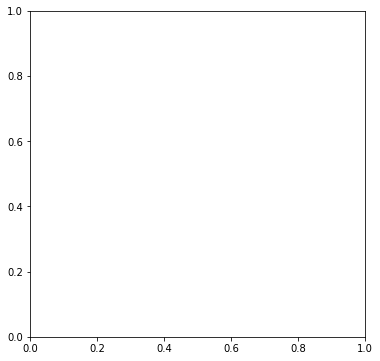

In [163]:
fig,ax2=  plt.subplots(1,1,figsize=(6,6))


ax2.plot((spec_HPb_0901.spectral_axis.value-g1_HPb_0901.mean.value)/g1_HPb_0901.mean.value *3E5,
         spec_HPb_0901.flux.value,lw=0.8,color='xkcd:red',label='20170901')
ax2.plot((spec_HPb_1123.spectral_axis.value-g1_HPb_1123.mean.value)/g1_HPb_1123.mean.value *3E5,
         spec_HPb_1123.flux.value,lw=0.8,color='xkcd:blue',label='20181123')
ax2.plot((spec_HPb_1123.spectral_axis.value-g1_HPb_1123.mean.value)/g1_HPb_1123.mean.value *3E5,
         g2_HPb_1123(spec_HPb_1123.spectral_axis),lw=0.5,
         color='xkcd:black',ls='--')
ax2.plot((spec_HPb_0901.spectral_axis.value-g1_HPb_0901.mean.value)/g1_HPb_0901.mean.value *3E5,
         g2_HPb_0901(spec_HPb_0901.spectral_axis),lw=0.5,
         color='xkcd:black',ls='--')

ax2.axes.set_xlim(-4000,4000)
ax2.axes.set_title(r'Paschen $\beta$')
ax2.legend()

plt.savefig('./HPB_plot.pdf')


plt.show()


In [ ]:
fig,ax3 =  plt.subplots(1,1,figsize=(6,6))

# ax1.plot(spec_HeI_1123.spectral_axis,np.log10(spec_HeI_1123.flux.value+1E-15),lw=0.5)
# ax1.plot(spec_HeI_0901.spectral_axis,np.log10(spec_HeI_0901.flux.value+1E-15),lw=0.5)

ax3.plot((spec_HeI_0901.spectral_axis.value-g1_HeI_0901.mean.value)/g1_HeI_0901.mean.value *3E5,
         spec_HeI_0901.flux.value,lw=0.8,color='xkcd:red',label='20170901')
ax3.plot((spec_HeI_1123.spectral_axis.value-g1_HeI_1123.mean.value)/g1_HeI_1123.mean.value *3E5,
         spec_HeI_1123.flux.value,lw=0.8,color='xkcd:blue',label='20181123')
ax3.plot((spec_HeI_1123.spectral_axis.value-g1_HeI_1123.mean.value)/g1_HeI_1123.mean.value *3E5,
         g2_HeI_1123(spec_HeI_1123.spectral_axis),lw=0.5,
         color='xkcd:black',ls='--')
ax3.plot((spec_HeI_0901.spectral_axis.value-g1_HeI_0901.mean.value)/g1_HeI_0901.mean.value *3E5,
         g2_HeI_0901(spec_HeI_0901.spectral_axis),lw=0.5,
         color='xkcd:black',ls='--')



ax3.axes.set_xlim(-4000,4000)
ax3.axes.set_ylim(-0.5E-16,0.6E-15)
ax3.axes.set_title(r'HeI')
ax3.legend()

# ax3.axes.set_xlim(-4000,4000)
# ax3.axes.set_title(r'Paschen $\beta$')
# ax3.legend()

plt.savefig('./HeI_plot.pdf')

#plt.show()


No Covariance matrix, trying single line fit
[4825, 4875]
(4.4085569976395015e-15, 2.9973920951141837e-16) (4.41+/-0.14)e-15


/home/UTU/thmire/anaconda2/envs/astroconda/lib/python3.7/site-packages/astropy/units/quantity.py:463: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


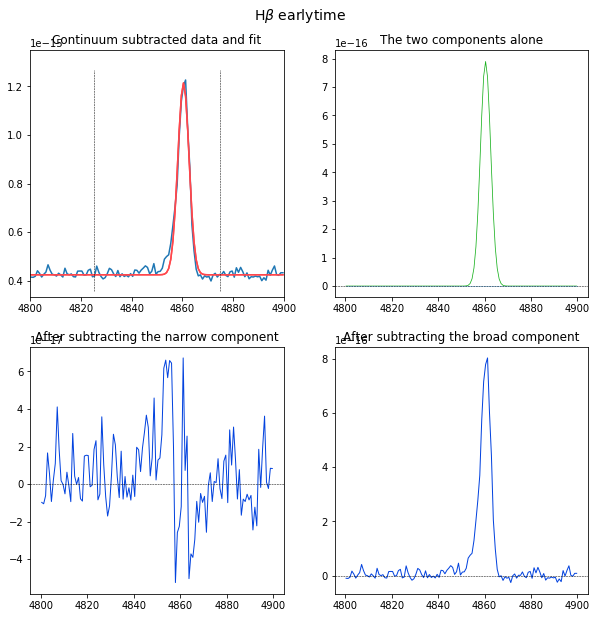

In [168]:
Hbeta = do_fit(ISIS_blue,[4800,4900],[4825,4875],4860,title=r'H$\beta$ optical ISIS')
#plt.savefig('/home/treynolds/data/iras23436/notebooks2/Hbeta.pdf',bbox_inches='tight')

[3850, 3950]
(-9.62477160732687e-16, 6.543913201219136e-17) (-9.6+/-1.3)e-16
(-6.447325511890249e-16, 4.3835573715623374e-17) (-6.4+/-1.7)e-16


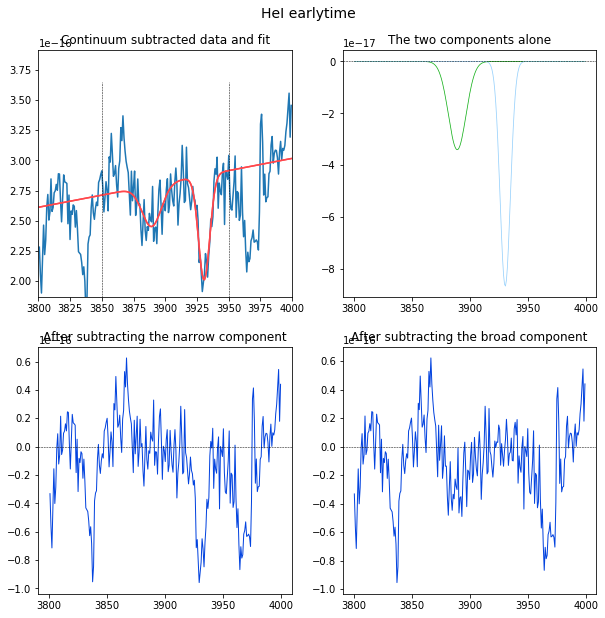

In [170]:
CaNIR = do_fit(ISIS_blue,[3800,4000],[3850,3950],3889,title=r'HeI earlytime')
#plt.savefig('/home/treynolds/data/iras23436/notebooks2/Hbeta.pdf',bbox_inches='tight')

[ 7130.36358356  7131.72495365  7133.08632374 ... 25643.44406128
 25647.02272415 25650.60377121] [-4.77453996e-16 -3.27366714e-15  7.57070041e-17 ... -2.81075432e-14
  5.30998263e-15  5.45597172e-15]
No Covariance matrix, trying single line fit
[21450, 21850]
(2.6221275869906592e-15, 1.7827929877413428e-16) (2.6+/-0.4)e-15


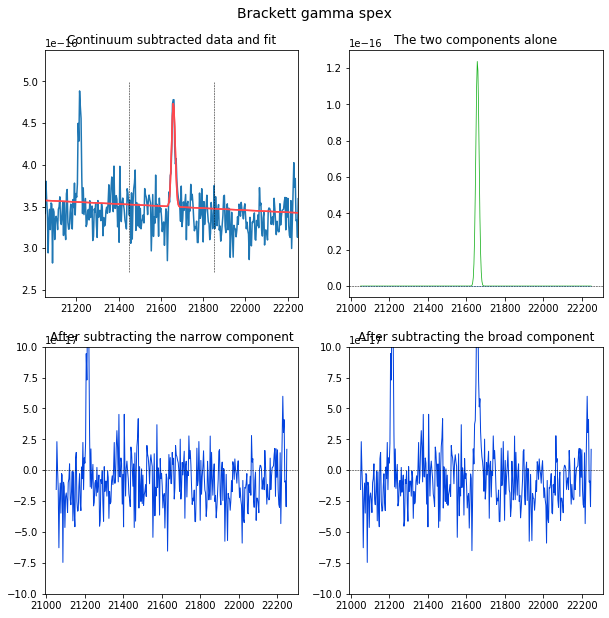

In [171]:
Spex_wl = np.loadtxt('/home/UTU/thmire/data/iras23436/specplots/SPEX_new_wl.txt',unpack='yes')[1] *1E4
Spex_flux = np.loadtxt('/home/UTU/thmire/data/iras23436/specplots/SPEX_new_flux.txt',unpack='yes')[1]
print(Spex_wl,Spex_flux)

HBry_0901 = do_fit([Spex_wl,Spex_flux],[21050,22250],[21450,21850],21660,
                   line_amps=(1E-16,1E-17,0,0),line_fwhms=(13,60,0,0),
                   title='Brackett gamma spex',plotwindowsize=((-1E-16,1E-16),(-1E-16,1E-16)))


[18550, 18900]
(8.204267973895178e-15, 5.578108207709897e-16) (8+/-4)e-15
(1.8690639656055426e-14, 1.2707826072724472e-15) (1.87+/-0.17)e-14
301+/-21
(1.5+/-0.5)e+03


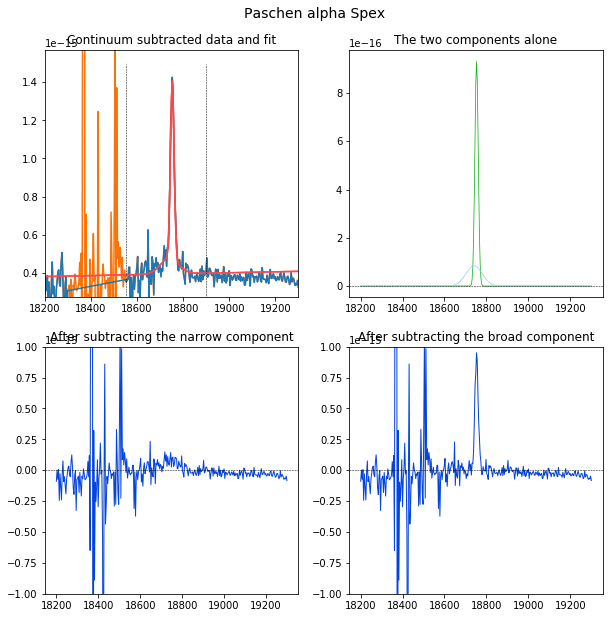

In [172]:
HPa_Spex = do_fit([Spex_wl,Spex_flux],[18200,19300],[18550,18900],18751,title='Paschen alpha Spex',exclude=(18300,18550),
                  line_amps=(4E-16,1E-16,0,0),line_fwhms=(5,100,0,0),
                  fixed='no',plotwindowsize=((-1E-15,1E-15),(-1E-15,1E-15)))

print(HPa_Spex[0][0][2]/HPa_Spex[0][0][1] *3E5*2.35)
print(HPa_Spex[0][1][2]/HPa_Spex[0][0][1] *3E5*2.35)

# ax =plt.gca()

# ax.plot([1,2],[10,20])

np.savetxt("/home/UTU/thmire/data/iras23436/specplots/Spex_spectrum.txt",
           np.array([Spex_wl,Spex_flux]).transpose(),fmt='%1.4e')

plt.savefig('/home/UTU/thmire/data/iras23436/plots/Spex_temp.pdf')

No Covariance matrix, trying single line fit
[10700, 10900]
(5.9030461703521335e-15, 4.013500094925016e-16) (5.9+/-1.8)e-15
(3.6+/-0.8)e+02
0.0+/-0


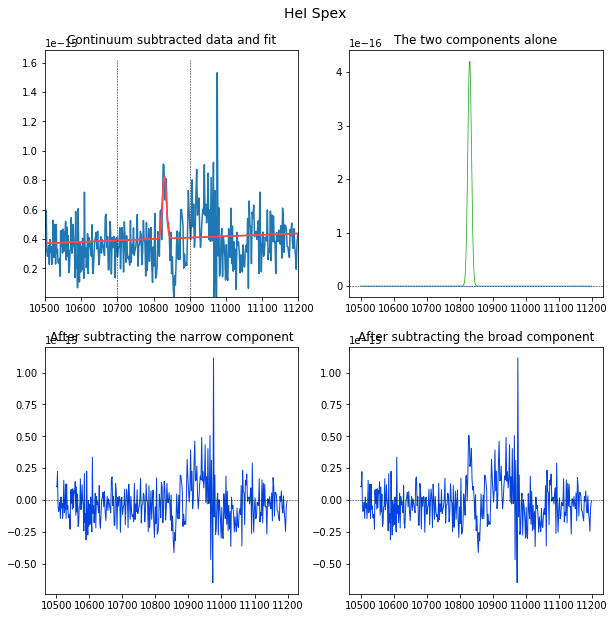

In [176]:
HeI_0901 = do_fit([Spex_wl,Spex_flux],[10500,11200],[10700,10900],10830,#exclude=[10920,10960],
                  line_amps=(7E-16,1E-16,0,0),line_fwhms=(10,0,0,0),
                  title='HeI Spex',window=(0.01,1.1))

print(HeI_0901[0][0][2]/HeI_0901[0][0][1] *3E5*2.35)
print(HeI_0901[0][1][2]/HeI_0901[0][0][1] *3E5*2.35)

No Covariance matrix, trying single line fit
[12650, 12950]
(7.907005235783047e-15, 5.375998314966075e-16) (7.9+/-1.1)e-15
263+/-28
0.0+/-0


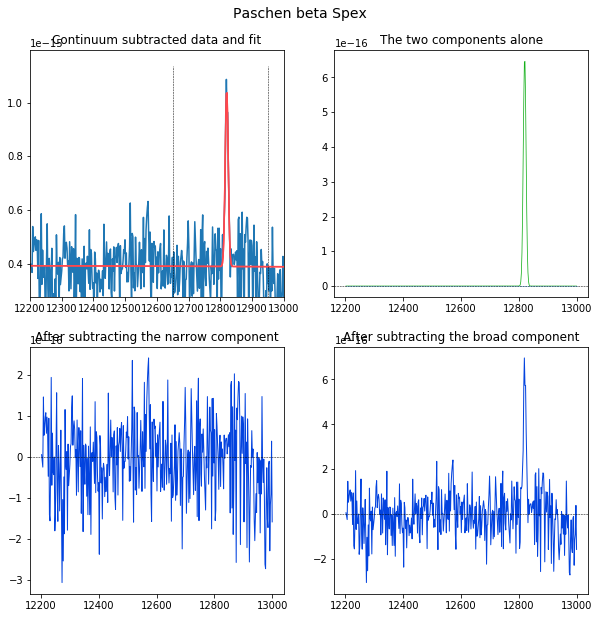

In [177]:
HPb_Spex = do_fit([Spex_wl,Spex_flux],[12200,13000],[12650,12950],12818,title='Paschen beta Spex')

print(HPb_Spex[0][0][2]/HPb_Spex[0][0][1] *3E5*2.35)
print(HPb_Spex[0][1][2]/HPb_Spex[0][0][1] *3E5*2.35)

[9970, 10110]
(-8.069890074579292e-15, 5.486744241401654e-16) (-8.1+/-3.4)e-15
(1.2646515285599919e-15, 8.59840645509024e-17) (1.3+/-1.0)e-15


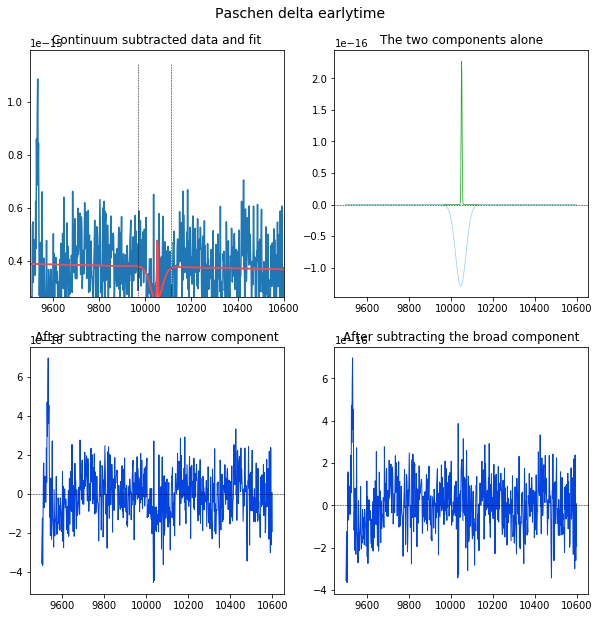

In [178]:
HPd_0901 = do_fit([Spex_wl,Spex_flux],[9500,10600],[9970,10110],10050,title='Paschen delta earlytime')